# Reinforcement Learning

# 5. Gradient Methods

This notebook presents gradient methods, useful for learning in some environment with a large state space.

We use a neural network with a single hidden layer.


In [1]:
import sys
from pathlib import Path

lib_path = str(Path.cwd().parent)

if lib_path not in sys.path:
    sys.path.append(lib_path)
print(sys.path)

['C:\\Python312\\python312.zip', 'C:\\Python312\\DLLs', 'C:\\Python312\\Lib', 'C:\\Python312', 'd:\\Code\\Reinforcement Learning\\venv', '', 'd:\\Code\\Reinforcement Learning\\venv\\Lib\\site-packages', 'd:\\Code\\Reinforcement Learning\\venv\\Lib\\site-packages\\win32', 'd:\\Code\\Reinforcement Learning\\venv\\Lib\\site-packages\\win32\\lib', 'd:\\Code\\Reinforcement Learning\\venv\\Lib\\site-packages\\Pythonwin', 'd:\\Code\\Reinforcement Learning']


In [2]:
from tqdm.notebook import tqdm

import numpy as np
from matplotlib import pyplot as plt

In [3]:
from lib.model import TicTacToe, ConnectFour
from lib.agent import Agent, OnlineEvaluation
from lib.dynamic import ValueIteration

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

## Value gradient


We start with value-based methods. The neural network is a regressor that approximates the value function. Note that the model is supposed to be known, so that we don't need the action-value function.


In [5]:
class Regressor(nn.Module):
    """Neural network for value function approximation. Return the value of each state."""

    def __init__(self, model, hidden_size):
        if not hasattr(model, "one_hot_encode"):
            raise ValueError("The environment must have a one-hot encoding of states.")
        super(Regressor, self).__init__()
        self.model = model
        state = model.init_state()
        code = model.one_hot_encode(state)
        input_size = len(code)
        self.nn = nn.Sequential(
            nn.Linear(input_size, hidden_size), nn.GELU(), nn.Linear(hidden_size, 1)
        )

    def forward(self, code):
        """Forward pass."""
        return self.nn(code)

In [6]:
game = TicTacToe()

In [7]:
regressor = Regressor(model=game, hidden_size=100)

In [8]:
state = game.state
code = game.one_hot_encode(state)
code = torch.tensor(code).float()

In [9]:
value = regressor.forward(code).detach()
print(value)

tensor([-0.0613])


## To do

- Complete the method get_best_actions of the class ValueGradient.
- Test the agent on TicTacToe, against (1) a random adversary and (2) a perfect adversary.
- Test the agent on ConnectFour, against (1) a random adversary and (2) an adversary with the one-step policy.
- Compare your results to another learning strategy (e.g., Monte-Carlo learning) and interpret the results.


In [10]:
class ValueGradient(OnlineEvaluation):
    """Agent learning by value gradient. The model is supposed to be known.

    Parameters
    ----------
    model : object of class Environment
        Model.
    player : int
        Player for games (1 or -1, default = default player of the game).
    gamma : float
        Discount rate (in [0, 1], default = 1).
    hidden_size : int
        Size of the hidden layer (default = 100).
    """

    def __init__(self, model, player=None, gamma=1, hidden_size=100):
        super(ValueGradient, self).__init__(model, player=player)
        if not hasattr(model, "get_next_state"):
            raise ValueError("The model must be known, with a 'get_next_state' method.")
        self.nn = Regressor(model, hidden_size)
        self.gamma = gamma

    def get_best_actions(self, state):
        """Get the best actions in some state according to the value function."""
        actions = self.get_actions(state)

        if len(actions) > 1:
            # to be modified
            # if the state is terminal, take the actual value
            values = np.zeros(len(actions))

            for i, action in enumerate(actions):
                next_state = self.model.get_next_state(state, action)

                if self.model.is_terminal(next_state):
                    values[i] = self.model.get_reward(next_state)
                else:
                    code = self.model.one_hot_encode(next_state)
                    code = torch.tensor(code).float()
                    values[i] = self.nn.forward(code).detach()

            if self.player == 1:
                best_value = max(values)
            else:
                best_value = min(values)
            actions = [
                action for action, value in zip(actions, values) if value == best_value
            ]
        return actions

    def update_policy(self):
        self.policy = self.get_policy()

    def get_samples(self, horizon, epsilon):
        """Get samples from one episode under the epsilon-greedy policy."""
        self.policy = self.randomize_policy(epsilon=epsilon)
        self.model.reset()
        state = self.model.state
        states = []
        rewards = []

        for _ in range(horizon):
            action = self.get_action(state)
            reward, stop = self.model.step(action)
            states.append(state)
            rewards.append(reward)
            if stop:
                break
            state = self.model.state

        gains = []
        gain = 0

        for reward in reversed(rewards):
            gain = reward + self.gamma * gain
            gains.append(gain)

        return reversed(states), gains

    def train(self, horizon=100, n_episodes=1000, learning_rate=0.01, epsilon=0.1):
        """Train the neural network with samples drawn from the epsilon-greedy policy."""
        optimizer = optim.Adam(self.nn.parameters(), lr=learning_rate)

        for _ in range(n_episodes):
            states, gains = self.get_samples(horizon, epsilon)
            codes = [self.model.one_hot_encode(state) for state in states]
            codes = np.array(codes)
            codes = torch.tensor(codes).float()
            values = self.nn.forward(codes)
            gains = torch.tensor(gains).float().reshape(-1, 1)
            mse = nn.MSELoss()
            loss = mse(values, gains)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

In [11]:
class MCLearning(OnlineEvaluation):
    """Online evaluation by Monte-Carlo."""

    def update_values(self, state=None, horizon=100):
        """Update the values from one episode."""
        stop, states, rewards = self.get_episode(state=state, horizon=horizon)
        # remove last state
        states.pop()
        gain = 0
        # backward update
        for state, reward in zip(reversed(states), reversed(rewards)):
            self.add_state(state)
            code = self.model.encode(state)
            self.count[code] += 1
            # to be modified
            # begin
            gain = reward + self.gamma * gain
            # end
            diff = gain - self.value[code]
            count = self.count[code]
            self.value[code] += diff / count

    def update_policy(self):
        self.policy = self.get_policy()

In [12]:
class TDLearning(OnlineEvaluation):
    """Online evaluation by TD learning."""

    def update_values(self, state=None, horizon=100):
        """Update values online from one episode."""
        self.model.reset(state)
        for _ in range(horizon):
            state = self.model.state
            # to be completed
            if self.model.is_terminal(state):
                break
            action = self.get_action(state)
            reward, stop = self.model.step(action)
            next_state = self.model.state
            self.add_state(state)
            self.add_state(next_state)
            code = self.model.encode(state)
            next_code = self.model.encode(next_state)
            self.count[code] += 1
            gain = reward + self.gamma * self.value[next_code]
            diff = gain - self.value[code]
            self.value[code] += diff / self.count[code]

    def update_policy(self):
        self.policy = self.get_policy()

In [13]:
def plot_gains(gains, title, data_points=10, step=1000):
    plt.figure(figsize=(8, 5))
    plt.title(title)
    plt.xlabel("Number of games")
    plt.xticks(
        ticks=np.linspace(0, data_points, data_points + 1, dtype=int),
        labels=np.linspace(0, data_points * step, data_points + 1, dtype=int),
    )
    plt.ylabel("Gain")
    for k, v in gains.items():
        plt.plot(v, label=k, marker="o")
    plt.legend()
    plt.show()

In [14]:
def run(algo, model, data_points=10, step=1000):
    agent = algo(model)
    avg_gains = []

    gains = agent.get_gains(n_runs=100)
    avg_gains.append(np.mean(gains))

    if type(agent) == MCLearning or type(agent) == TDLearning:
        for i in tqdm(range(1, (data_points * step) + 1)):
            agent.update_values()

            if i % step == 0:
                agent.update_policy()
                gains = agent.get_gains(n_runs=100)
                avg_gains.append(np.mean(gains))
    else:
        for i in tqdm(range(1, data_points + 1)):
            agent.train()
            agent.update_policy()
            gains = agent.get_gains(n_runs=100)
            avg_gains.append(np.mean(gains))

    return avg_gains

### Tic-Tac-Toe


In [15]:
game = TicTacToe()
agent = ValueGradient(game)

In [16]:
gains = agent.get_gains(n_runs=100)
np.unique(gains, return_counts=True)

(array([-1,  0,  1]), array([34, 12, 54]))

#### Random adversary


In [17]:
vg_gains = run(ValueGradient, game)

  0%|          | 0/10 [00:00<?, ?it/s]

In [18]:
mc_gains = run(MCLearning, game)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [19]:
td_gains = run(TDLearning, game)

  0%|          | 0/10000 [00:00<?, ?it/s]

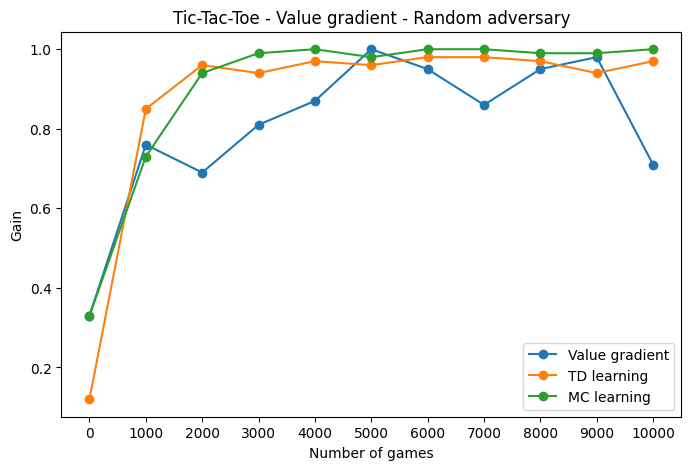

In [20]:
plot_gains(
    gains={
        "Value gradient": vg_gains,
        "TD learning": td_gains,
        "MC learning": mc_gains,
    },
    title="Tic-Tac-Toe - Value gradient - Random adversary",
)

We can see that the agent trained with the value gradient method is able to obtain an average gain close to 1.0.

The results are similar to those obtained with MC and TD learning methods.


#### Perfect adversary


In [21]:
algo = ValueIteration(game)
_, adversary_policy = algo.get_perfect_players()
game = TicTacToe(adversary_policy=adversary_policy)

In [22]:
vg_gains = run(ValueGradient, game)

  0%|          | 0/10 [00:00<?, ?it/s]

In [23]:
mc_gains = run(MCLearning, game)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [24]:
td_gains = run(TDLearning, game)

  0%|          | 0/10000 [00:00<?, ?it/s]

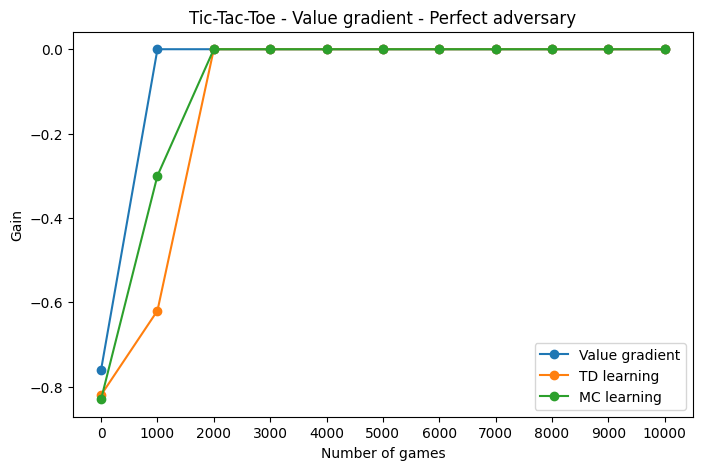

In [25]:
plot_gains(
    gains={
        "Value gradient": vg_gains,
        "TD learning": td_gains,
        "MC learning": mc_gains,
    },
    title="Tic-Tac-Toe - Value gradient - Perfect adversary",
)

Also in this graph we can see that the 3 methods have similar results.

Of course, in this case, the agent will only converge to a value close to 0.0, since the adversary is perfect, and the best the agent can do is to draw the game.

We can also observe that TD learning converges slightly slower than the other methods.


### Connect Four


In [26]:
game = ConnectFour()
agent = ValueGradient(game)

In [27]:
gains = agent.get_gains(n_runs=100)
np.unique(gains, return_counts=True)

(array([-1,  0,  1]), array([42,  1, 57]))

#### Random adversary


In [28]:
vg_gains = run(ValueGradient, game)

  0%|          | 0/10 [00:00<?, ?it/s]

In [29]:
mc_gains = run(MCLearning, game)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [30]:
td_gains = run(TDLearning, game)

  0%|          | 0/10000 [00:00<?, ?it/s]

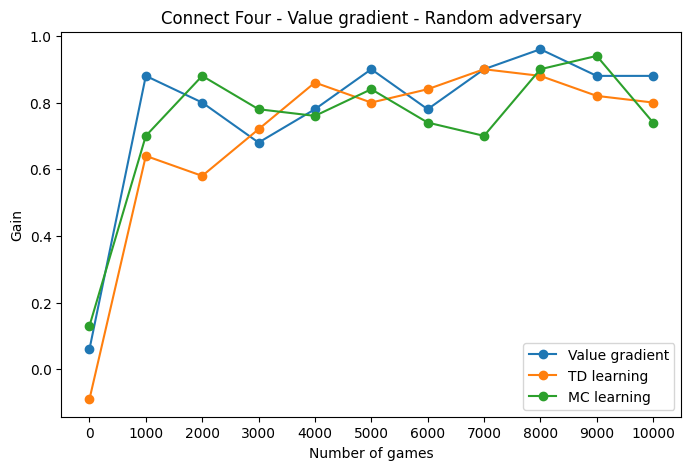

In [31]:
plot_gains(
    gains={
        "Value gradient": vg_gains,
        "TD learning": td_gains,
        "MC learning": mc_gains,
    },
    title="Connect Four - Value gradient - Random adversary",
)

In connect four, against a random adversary, we manage to converge to a value close to 0.8.

The 3 methods have comparable results.


#### One-step adversary


In [32]:
game = ConnectFour(adversary_policy="one_step")

In [33]:
vg_gains = run(ValueGradient, game)

  0%|          | 0/10 [00:00<?, ?it/s]

In [34]:
mc_gains = run(MCLearning, game)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [35]:
td_gains = run(TDLearning, game)

  0%|          | 0/10000 [00:00<?, ?it/s]

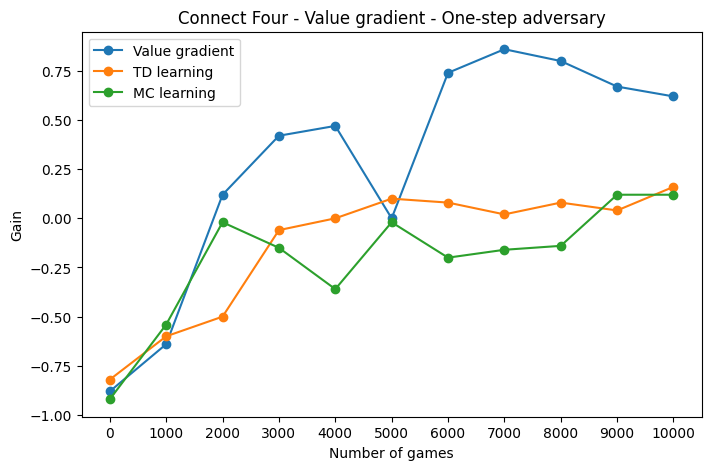

In [36]:
plot_gains(
    gains={
        "Value gradient": vg_gains,
        "TD learning": td_gains,
        "MC learning": mc_gains,
    },
    title="Connect Four - Value gradient - One-step adversary",
)

Against a one-step adversary, value gradient learning shows better performance than the other methods.


## Policy gradient


We now consider a policy-based method. The neural network is a classifier that approximates the optimal policy. It returns the probability of each action.


In [37]:
class Classifier(nn.Module):
    """Neural network for policy gradient. Return the distribution of actions in each state."""

    def __init__(self, model, hidden_size):
        if not hasattr(model, "one_hot_encode"):
            raise ValueError("The environment must have a one-hot encoding of states.")
        super(Classifier, self).__init__()
        self.model = model
        actions = model.get_all_actions()
        if self.model.is_game():
            # remove action when passing
            actions.pop()
        self.actions = actions
        state = model.init_state()
        code = model.one_hot_encode(state)
        input_size = len(code)
        output_size = len(actions)
        self.nn = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.GELU(),
            nn.Linear(hidden_size, output_size),
            nn.Softmax(dim=0),
        )

    def forward(self, code):
        """Forward pass."""
        return self.nn(code)

In [38]:
game = TicTacToe()
classifier = Classifier(model=game, hidden_size=100)

In [39]:
state = game.state
code = game.one_hot_encode(state)
code = torch.tensor(code).float()

In [40]:
probs = classifier.forward(code).detach()
print(probs)
print(len(probs))
print(sum(probs))

tensor([0.1077, 0.1058, 0.1096, 0.1193, 0.1056, 0.1157, 0.1087, 0.1179, 0.1096])
9
tensor(1.0000)


## To do

- Complete the method 'train' of the class PolicyGradient. Observe that a penalty is assigned for illegal actions.
- Test the agent on TicTacToe, against (1) a random adversary and (2) a perfect adversary.
- Test the agent on ConnectFour, against (1) a random adversary and (2) an adversary with the one-step policy.
- Compare your results to another learning strategy (e.g., Monte-Carlo learning) and interpret the results.
- (bonus) Try to improve policy gradient on TicTacToe with a perfect adversary.


In [41]:
class PolicyGradient(Agent):
    """Agent learning by policy gradient.

    Parameters
    ----------
    model : object of class Environment
        Model.a
    player : int
        Player for games (1 or -1, default = default player of the game).
    gamma : float
        Discount rate (in [0, 1], default = 1).
    hidden_size : int
        Size of the hidden layer (default = 100).
    penalty : float
        Penalty for illegal actions (default = -5).
    min_log : float
        Minimal value to compute the log (default = 1e-10)
    """

    def __init__(
        self, model, player=None, gamma=1, hidden_size=100, penalty=-1, min_log=1e-10
    ):
        super(PolicyGradient, self).__init__(model, player=player)
        self.nn = Classifier(model, hidden_size)
        self.action_id = {action: i for i, action in enumerate(self.nn.actions)}
        self.gamma = gamma
        self.penalty = penalty
        self.min_log = min_log
        self.running_mean_gain = 0
        self.alpha = 0.01

    def get_policy(self):
        """Get the current policy."""

        def policy(state):
            actions = self.model.get_actions(state)

            if len(actions) > 1:
                win_actions = []
                # check win actions
                if self.model.is_game():
                    next_states = [
                        self.model.get_next_state(state, action) for action in actions
                    ]
                    win_actions = [
                        self.model.get_reward(next_state) == self.player
                        for next_state in next_states
                    ]
                if any(win_actions):
                    probs = np.array(win_actions).astype(float)
                else:
                    # get prob of each action
                    code = self.model.one_hot_encode(state)
                    code = torch.tensor(code).float()
                    probs = self.nn.forward(code)
                    probs = probs.detach().numpy()
                    # restrict to available actions
                    indices = [self.action_id[action] for action in actions]
                    probs = probs[indices]
                # renormalize
                if np.sum(probs) > 0:
                    probs = probs / np.sum(probs)
                else:
                    probs = np.ones(len(actions)) / len(actions)
            else:
                probs = [1]
            return probs, actions

        return policy

    def update_policy(self):
        """Update the policy."""
        self.policy = self.get_policy()

    def get_samples(self, horizon):
        """Get samples from one episode."""
        self.update_policy()
        rewards = []
        log_probs = []
        log_probs_illegal = []
        self.model.reset()
        state = self.model.state

        for _ in range(horizon):
            action = self.get_action(state)
            if action is not None:
                i = self.action_id[action]
                code = self.model.one_hot_encode(state)
                code = torch.tensor(code).float()
                probs = self.nn.forward(code)
                prob = torch.clip(probs[i], self.min_log, 1 - self.min_log)
                log_prob = torch.log(prob).reshape(1)

                actions = self.model.get_actions(state)
                if action in actions:
                    reward, stop = self.model.step(action)
                    state = self.model.state
                    rewards.append(reward)
                    log_probs.append(log_prob)
                else:
                    log_probs_illegal.append(log_prob)
            else:
                reward, stop = self.model.step(action)
                rewards.append(reward)
                state = self.model.state
            if stop:
                break

        gain = 0
        for reward in reversed(rewards):
            gain = reward + self.gamma * gain

        return gain, log_probs, log_probs_illegal

    def train(self, horizon=100, n_episodes=1000, learning_rate=0.01):
        """Train the neural network."""
        optimizer = optim.Adam(self.nn.parameters(), lr=learning_rate)

        for _ in range(n_episodes):
            gain, log_probs, log_probs_illegal = self.get_samples(horizon)

            # incremental mean
            self.running_mean_gain += self.alpha * (gain - self.running_mean_gain)
            loss = 0

            if len(log_probs):
                # to be modified
                for log_prob in log_probs:
                    # center the gain
                    centered_gain = gain - self.running_mean_gain
                    for log_prob in log_probs:
                        loss += -log_prob * centered_gain

            if len(log_probs_illegal):
                for log_prob in log_probs_illegal:
                    loss += self.penalty * log_prob

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

### Tic-Tac-Toe


In [42]:
game = TicTacToe()
agent = PolicyGradient(game)

In [43]:
gains = agent.get_gains(n_runs=100)
np.unique(gains, return_counts=True)

(array([-1,  0,  1]), array([28, 10, 62]))

#### Random adversary


In [44]:
pg_gains = run(PolicyGradient, game)

  0%|          | 0/10 [00:00<?, ?it/s]

In [45]:
mc_gains = run(MCLearning, game)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [46]:
td_gains = run(TDLearning, game)

  0%|          | 0/10000 [00:00<?, ?it/s]

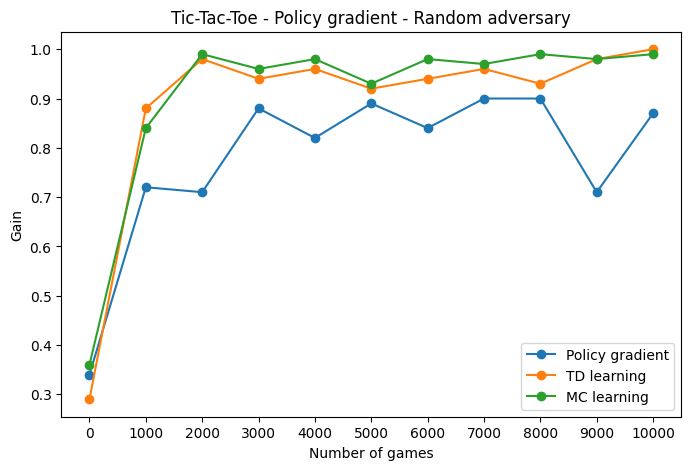

In [47]:
plot_gains(
    gains={
        "Policy gradient": pg_gains,
        "TD learning": td_gains,
        "MC learning": mc_gains,
    },
    title="Tic-Tac-Toe - Policy gradient - Random adversary",
)

Using policy gradient, we can see that the agent is able to obtain an average gain close to 1.0.

Similar to the value gradient method, the results are similar to those obtained with MC and TD learning methods in the case of a random adversary playing Tic-Tac-Toe.


#### Perfect adversary


In [48]:
algo = ValueIteration(game)
_, adversary_policy = algo.get_perfect_players()
game = TicTacToe(adversary_policy=adversary_policy)

In [49]:
pg_gains = run(PolicyGradient, game)

  0%|          | 0/10 [00:00<?, ?it/s]

In [50]:
mc_gains = run(MCLearning, game)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [51]:
td_gains = run(TDLearning, game)

  0%|          | 0/10000 [00:00<?, ?it/s]

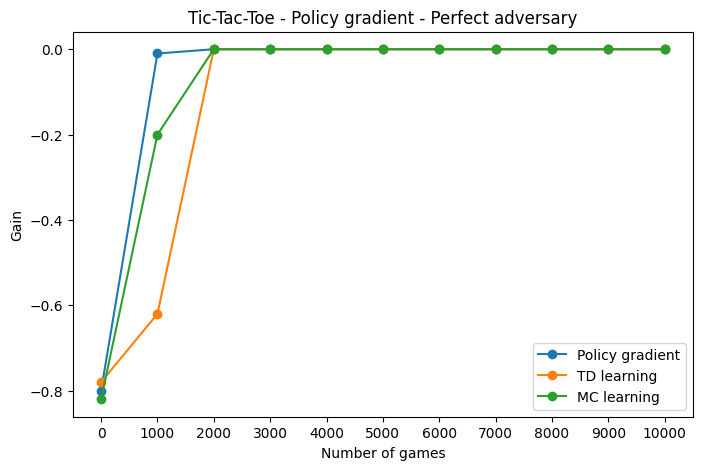

In [52]:
plot_gains(
    gains={
        "Policy gradient": pg_gains,
        "TD learning": td_gains,
        "MC learning": mc_gains,
    },
    title="Tic-Tac-Toe - Policy gradient - Perfect adversary",
)

Since the gain can only be 0 or -1, we need to center the gains used for the loss computation by its incremental mean.

This approach allows the agent to converge to a value close to 0.0.

The results are similar to those obtained with MC and TD learning methods.


### Connect Four


In [53]:
game = ConnectFour()
agent = PolicyGradient(game)

In [54]:
gains = agent.get_gains(n_runs=100)
np.unique(gains, return_counts=True)

(array([-1,  0,  1]), array([43,  1, 56]))

#### Random adversary


In [55]:
pg_gains = run(PolicyGradient, game)

  0%|          | 0/10 [00:00<?, ?it/s]

In [56]:
mc_gains = run(MCLearning, game)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [57]:
td_gains = run(TDLearning, game)

  0%|          | 0/10000 [00:00<?, ?it/s]

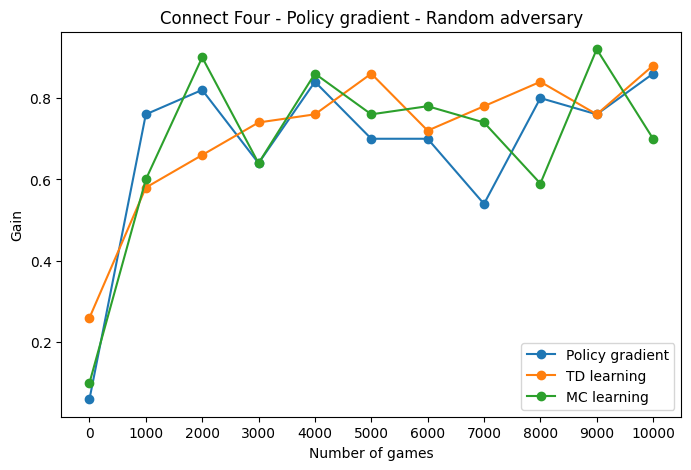

In [58]:
plot_gains(
    gains={
        "Policy gradient": pg_gains,
        "TD learning": td_gains,
        "MC learning": mc_gains,
    },
    title="Connect Four - Policy gradient - Random adversary",
)

Policy gradient learning shows good performance against a random adversary in Connect Four.

The final average gain is close to 0.8.


#### One-step adversary


In [59]:
game = ConnectFour(adversary_policy="one_step")

In [60]:
pg_gains = run(PolicyGradient, game)

  0%|          | 0/10 [00:00<?, ?it/s]

In [61]:
mc_gains = run(MCLearning, game)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [62]:
td_gains = run(TDLearning, game)

  0%|          | 0/10000 [00:00<?, ?it/s]

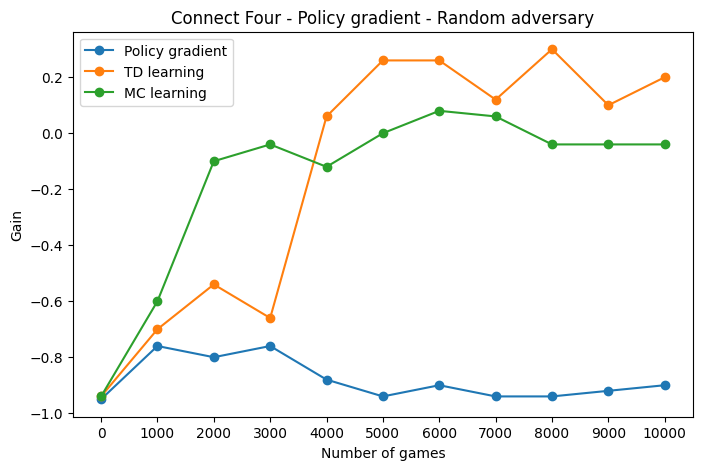

In [63]:
plot_gains(
    gains={
        "Policy gradient": pg_gains,
        "TD learning": td_gains,
        "MC learning": mc_gains,
    },
    title="Connect Four - Policy gradient - Random adversary",
)

Starting from a average gain close to -1.0, the agent is able to improve its performance and converge to a value higher than 0.0.

The game is more complex than Tic-Tac-Toe, so we don't see a rapid convergence to values close to 1.0.
